<a href="https://colab.research.google.com/github/rmontteiro/ML_IGTI_bootcamp/blob/master/Desafio2_mod4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
AUTOTUNE= tf.data.experimental.AUTOTUNE

In [7]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [12]:
print(tf.__version__)

2.3.0


Antes de iniciar qualquer treinamento, você precisará carregar o conjunto de imagens
para ensinar à rede as novas classes que deseja reconhecer. Vamos usar um arquivo
de fotos de flores licenciadas da creative-commons do Google.
O conjunto de dados usado neste exemplo é distribuído como diretórios de imagens,
com uma classe de imagem por diretório.
Se quiser conferir o banco de imagens, baixe as fotos de:
http://download.tensorflow.org/example_images/flower_photos.tgz

In [13]:
import pathlib


In [14]:
data_dir=tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                 fname='flower_photos', untar=True)
data_dir=pathlib.Path(data_dir)

Após o download (218MB), você deve ter uma cópia das fotos da flor disponível.
O diretório contém alguns subdiretórios, um por classe:

In [15]:
image_count=len(list(data_dir.glob('*/*.jpg')))
image_count

3670

O count retornará o número de imagens.

In [16]:
CLASS_NAMES=np.array([item.name for item in data_dir.glob('*') if item.name!='LICENSE.txt'])
CLASS_NAMES

array(['sunflowers', 'dandelion', 'tulips', 'daisy', 'roses'],
      dtype='<U10')

Cada diretório contém imagens desse tipo de flor. Aqui estão algumas rosas:

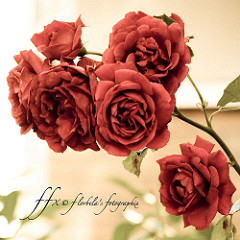

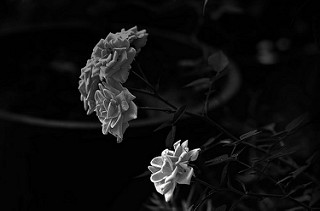

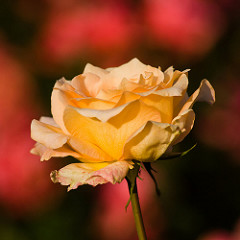

In [17]:
roses=list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
  display.display(Image.open(str(image_path)))


#incorporando o desafio

Using TensorFlow

Retreinando um classificador de imagens

Introdução
Os modelos de classificação de imagens têm milhões de parâmetros. Treiná-los do zero requer muitos dados de treinamento rotulados e muito poder de computação. A aprendizagem por transferência é uma técnica que reduz muito disso, pegando uma parte de um modelo que já foi treinado em uma tarefa relacionada e reutilizando-o em um novo modelo.

Este Colab demonstra como construir um modelo Keras para classificar cinco espécies de flores usando um SavedModel TF2 pré-treinado do TensorFlow Hub para extração de recursos de imagem, treinado no conjunto de dados ImageNet muito maior e mais geral. Opcionalmente, o extrator de recursos pode ser treinado ("ajustado") junto com o classificador recém-adicionado.

Procurando uma ferramenta?
Este é um tutorial de codificação do TensorFlow. Se você deseja uma ferramenta que constrói apenas o modelo TensorFlow ou TF Lite, dê uma olhada na ferramenta de linha de comando make_image_classifier que é instalada pelo pacote PIP tensorflow-hub[make_image_classifier] , ou neste colab TF Lite.

In [18]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.10.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


Selecione o módulo TF2 SavedModel para usar
Para começar, use https: //tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 . A mesma URL pode ser usada no código para identificar o SavedModel e em seu navegador para mostrar sua documentação. (Observe que os modelos no formato TF1 Hub não funcionam aqui.)

Você pode encontrar mais modelos TF2 que geram vetores de recursos de imagem aqui .

In [19]:
module_selection = ("mobilenet_v2_100_224", 224) 
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


Configure o conjunto de dados do Flowers
As entradas são redimensionadas adequadamente para o módulo selecionado. O aumento do conjunto de dados (ou seja, distorções aleatórias de uma imagem cada vez que ela é lida) melhora o treinamento, esp. durante o ajuste fino.

In [20]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [21]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


Definindo o modelo

Basta colocar um classificador linear no topo do feature_extractor_layer com o módulo Hub.

Para velocidade, começamos com um feature_extractor_layer não treinável, mas você também pode ativar o ajuste fino para maior precisão.

In [22]:
do_fine_tuning = False 

In [23]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


Treinando o modelo

In [24]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
91/91 [==============================] - 128s 1s/step - loss: 0.9593 - accuracy: 0.7327 - val_loss: 0.7509 - val_accuracy: 0.8438
Epoch 2/5
91/91 [==============================] - 127s 1s/step - loss: 0.6979 - accuracy: 0.8758 - val_loss: 0.7215 - val_accuracy: 0.8580
Epoch 3/5
91/91 [==============================] - 131s 1s/step - loss: 0.6559 - accuracy: 0.9013 - val_loss: 0.7361 - val_accuracy: 0.8509
Epoch 4/5
91/91 [==============================] - 128s 1s/step - loss: 0.6295 - accuracy: 0.9150 - val_loss: 0.6924 - val_accuracy: 0.8679
Epoch 5/5
91/91 [==============================] - 127s 1s/step - loss: 0.6064 - accuracy: 0.9267 - val_loss: 0.6759 - val_accuracy: 0.8750


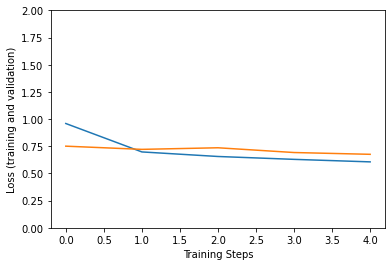

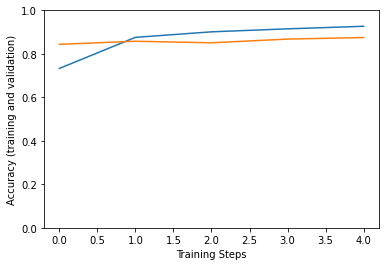

In [25]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Experimente o modelo em uma imagem dos dados de validação:

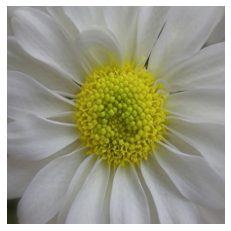

True label: daisy
Predicted label: daisy


In [26]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))


Finalmente, o modelo treinado pode ser salvo para implantação no TF Serving ou TF Lite (no celular) como segue.

In [27]:
saved_model_path = "/tmp/saved_flowers_model"
tf.saved_model.save(model, saved_model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


Classifique flores com transferência de aprendizagem

In [28]:
import collections
import io
import math
import os
import random
from six.moves import urllib

from IPython.display import clear_output, Image, display, HTML

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


O conjunto de dados de flores
O conjunto de dados de flores consiste em imagens de flores com 5 rótulos de classe possíveis.

Ao treinar um modelo de aprendizado de máquina, dividimos nossos dados em conjuntos de dados de treinamento e teste. Vamos treinar o modelo em nossos dados de treinamento e, em seguida, avaliar o desempenho do modelo em dados que nunca viu - o conjunto de teste.

Vamos baixar nossos exemplos de treinamento e teste (pode demorar um pouco) e dividi-los em conjuntos de treinamento e teste.

Execute as duas células a seguir:

In [29]:
FLOWERS_DIR = './flower_photos'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018


def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)


def make_train_and_test_sets():
  """Split the data into train and test sets and get the label classes."""
  train_examples, test_examples = [], []
  shuffler = random.Random(RANDOM_SEED)
  is_root = True
  for (dirname, subdirs, filenames) in tf.gfile.Walk(FLOWERS_DIR):
    # The root directory gives us the classes
    if is_root:
      subdirs = sorted(subdirs)
      classes = collections.OrderedDict(enumerate(subdirs))
      label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
      is_root = False
    # The sub directories give us the image files for training.
    else:
      filenames.sort()
      shuffler.shuffle(filenames)
      full_filenames = [os.path.join(dirname, f) for f in filenames]
      label = dirname.split('/')[-1]
      label_class = label_to_class[label]
      # An example is the image file and it's label class.
      examples = list(zip(full_filenames, [label_class] * len(filenames)))
      num_train = int(len(filenames) * TRAIN_FRACTION)
      train_examples.extend(examples[:num_train])
      test_examples.extend(examples[num_train:])

  shuffler.shuffle(train_examples)
  shuffler.shuffle(test_examples)
  return train_examples, test_examples, classes


In [30]:
# Download the images and split the images into train and test sets.
download_images()
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)

print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))

Flower photos are located in ./flower_photos

The dataset has 5 label classes: odict_values(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
There are 2934 training images
there are 736 test images


Explore os dados
O conjunto de dados de flores consiste em exemplos que são imagens rotuladas de flores. Cada exemplo contém uma imagem de flor JPEG e o rótulo da classe: que tipo de flor é. Vamos mostrar algumas imagens junto com seus rótulos.

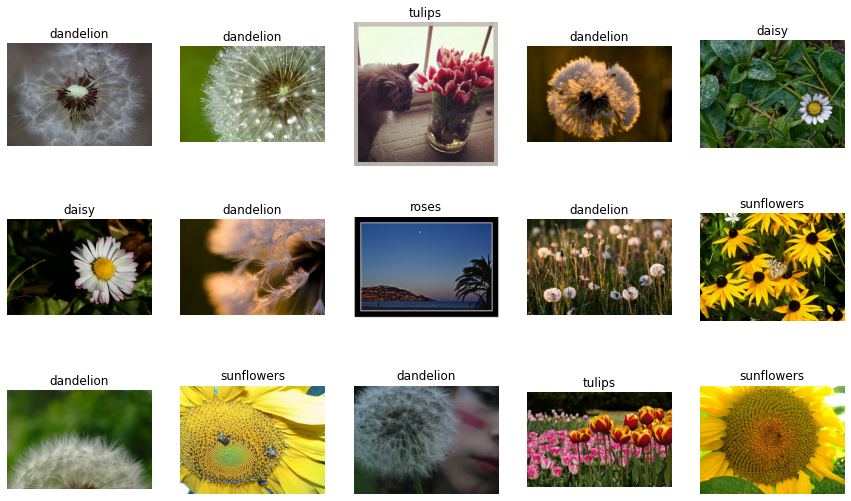

In [31]:
def get_label(example):
  """Get the label (number) for given example."""
  return example[1]

def get_class(example):
  """Get the class (string) of given example."""
  return CLASSES[get_label(example)]

def get_encoded_image(example):
  """Get the image data (encoded jpg) of given example."""
  image_path = example[0]
  return tf.gfile.GFile(image_path, 'rb').read()

def get_image(example):
  """Get image as np.array of pixels for given example."""
  return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
  """Display given images and their labels in a grid."""
  rows = int(math.ceil(len(images_and_classes) / cols))
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  for i, (image, flower_class) in enumerate(images_and_classes):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(flower_class)

NUM_IMAGES = 15 
display_images([(get_image(example), get_class(example))
               for example in TRAIN_EXAMPLES[:NUM_IMAGES]])

Construir o modelo
Vamos carregar um módulo de vetor de recursos de imagem TF-Hub , empilhar um classificador linear nele e adicionar operações de treinamento e avaliação. A célula a seguir constrói um gráfico TF que descreve o modelo e seu treinamento, mas não executa o treinamento (essa será a próxima etapa).

In [32]:
LEARNING_RATE = 0.01

tf.reset_default_graph()

# Load a pre-trained TF-Hub module for extracting features from images. We've
# chosen this particular module for speed, but many other choices are available.
image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2')

# Preprocessing images into tensors with size expected by the image module.
encoded_images = tf.placeholder(tf.string, shape=[None])
image_size = hub.get_expected_image_size(image_module)


def decode_and_resize_image(encoded):
  decoded = tf.image.decode_jpeg(encoded, channels=3)
  decoded = tf.image.convert_image_dtype(decoded, tf.float32)
  return tf.image.resize_images(decoded, image_size)


batch_images = tf.map_fn(decode_and_resize_image, encoded_images, dtype=tf.float32)

# The image module can be applied as a function to extract feature vectors for a
# batch of images.
features = image_module(batch_images)


def create_model(features):
  """Build a model for classification from extracted features."""
  # Currently, the model is just a single linear layer. You can try to add
  # another layer, but be careful... two linear layers (when activation=None)
  # are equivalent to a single linear layer. You can create a nonlinear layer
  # like this:
  # layer = tf.layers.dense(inputs=..., units=..., activation=tf.nn.relu)
  layer = tf.layers.dense(inputs=features, units=NUM_CLASSES, activation=None)
  return layer


# For each class (kind of flower), the model outputs some real number as a score
# how much the input resembles this class. This vector of numbers is often
# called the "logits".
logits = create_model(features)
labels = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# Mathematically, a good way to measure how much the predicted probabilities
# diverge from the truth is the "cross-entropy" between the two probability
# distributions. For numerical stability, this is best done directly from the
# logits, not the probabilities extracted from them.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

# Let's add an optimizer so we can train the network.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss=cross_entropy_mean)

# The "softmax" function transforms the logits vector into a vector of
# probabilities: non-negative numbers that sum up to one, and the i-th number
# says how likely the input comes from class i.
probabilities = tf.nn.softmax(logits)

# We choose the highest one as the predicted class.
prediction = tf.argmax(probabilities, 1)
correct_prediction = tf.equal(prediction, tf.argmax(labels, 1))

# The accuracy will allow us to eval on our test set. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Treine a rede
Agora que nosso modelo está construído, vamos treiná-lo e ver como ele funciona em nosso conjunto de teste.

In [33]:
# How long will we train the network (number of batches).
NUM_TRAIN_STEPS = 100 
# How many training examples we use in each step.
TRAIN_BATCH_SIZE = 10 
# How often to evaluate the model performance.
EVAL_EVERY = 10 

def get_batch(batch_size=None, test=False):
  """Get a random batch of examples."""
  examples = TEST_EXAMPLES if test else TRAIN_EXAMPLES
  batch_examples = random.sample(examples, batch_size) if batch_size else examples
  return batch_examples

def get_images_and_labels(batch_examples):
  images = [get_encoded_image(e) for e in batch_examples]
  one_hot_labels = [get_label_one_hot(e) for e in batch_examples]
  return images, one_hot_labels

def get_label_one_hot(example):
  """Get the one hot encoding vector for the example."""
  one_hot_vector = np.zeros(NUM_CLASSES)
  np.put(one_hot_vector, get_label(example), 1)
  return one_hot_vector

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(NUM_TRAIN_STEPS):
    # Get a random batch of training examples.
    train_batch = get_batch(batch_size=TRAIN_BATCH_SIZE)
    batch_images, batch_labels = get_images_and_labels(train_batch)
    # Run the train_op to train the model.
    train_loss, _, train_accuracy = sess.run(
        [cross_entropy_mean, train_op, accuracy],
        feed_dict={encoded_images: batch_images, labels: batch_labels})
    is_final_step = (i == (NUM_TRAIN_STEPS - 1))
    if i % EVAL_EVERY == 0 or is_final_step:
      # Get a batch of test examples.
      test_batch = get_batch(batch_size=None, test=True)
      batch_images, batch_labels = get_images_and_labels(test_batch)
      # Evaluate how well our model performs on the test set.
      test_loss, test_accuracy, test_prediction, correct_predicate = sess.run(
        [cross_entropy_mean, accuracy, prediction, correct_prediction],
        feed_dict={encoded_images: batch_images, labels: batch_labels})
      print('Test accuracy at step %s: %.2f%%' % (i, (test_accuracy * 100)))

Test accuracy at step 0: 26.77%
Test accuracy at step 10: 53.67%
Test accuracy at step 20: 66.17%
Test accuracy at step 30: 69.16%
Test accuracy at step 40: 70.65%
Test accuracy at step 50: 73.91%
Test accuracy at step 60: 75.68%
Test accuracy at step 70: 75.00%
Test accuracy at step 80: 76.77%
Test accuracy at step 90: 78.67%
Test accuracy at step 99: 79.21%


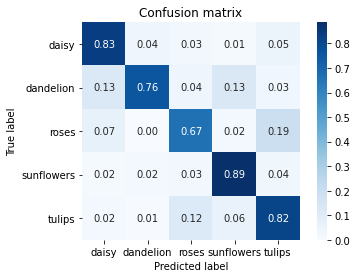

In [34]:
def show_confusion_matrix(test_labels, predictions):
  """Compute confusion matrix and normalize."""
  confusion = sk_metrics.confusion_matrix(
    np.argmax(test_labels, axis=1), predictions)
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = list(CLASSES.values())
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(batch_labels, test_prediction)

Previsões incorretas
Vamos dar uma olhada mais de perto nos exemplos de teste em que nosso modelo errou.

Existem exemplos com rótulos incorretos em nosso conjunto de teste?
Existem dados inválidos no conjunto de teste - imagens que não são realmente fotos de flores?
Existem imagens nas quais você pode entender por que o modelo cometeu um erro?

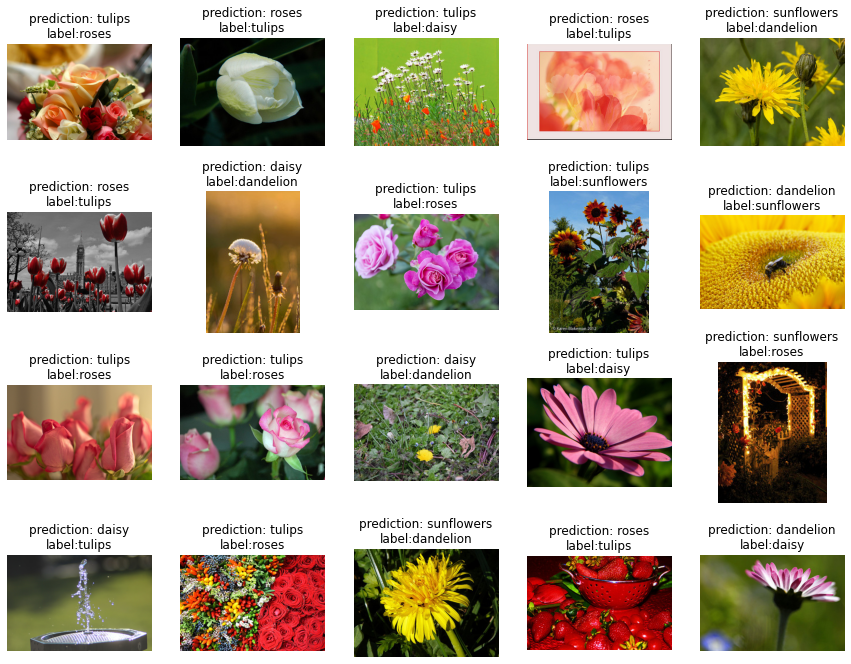

In [35]:
incorrect = [
    (example, CLASSES[prediction])
    for example, prediction, is_correct in zip(test_batch, test_prediction, correct_predicate)
    if not is_correct
]
display_images(
  [(get_image(example), "prediction: {0}\nlabel:{1}".format(incorrect_prediction, get_class(example)))
   for (example, incorrect_prediction) in incorrect[:20]])

Exercícios: Melhore o modelo!
Treinamos um modelo de linha de base, agora vamos tentar melhorá-lo para obter maior precisão. (Lembre-se de que você precisará executar novamente as células ao fazer uma alteração.)

Exercício 1: Experimente um modelo de imagem diferente.
Com o TF-Hub, tentar alguns modelos de imagem diferentes é simples. Basta substituir o identificador "https://tfhub.dev/google/imagenet/mobilenet_v2_050_128/feature_vector/2" na chamada hub.Module() por um identificador de módulo e código diferente. Você pode ver todos os módulos de imagem disponíveis em tfhub.dev .

Uma boa escolha pode ser um dos outros módulos MobileNet V2 . Muitos dos módulos - incluindo os módulos MobileNet - foram treinados no conjunto de dados ImageNet que contém mais de 1 milhão de imagens e 1000 classes. A escolha de uma arquitetura de rede oferece uma compensação entre velocidade e precisão de classificação: modelos como MobileNet ou NASNet Mobile são rápidos e pequenos, arquiteturas mais tradicionais como Inception e ResNet foram projetadas para precisão.

Para a arquitetura maior do Inception V3, você também pode explorar os benefícios do pré-treinamento em um domínio mais próximo de sua própria tarefa: ele também está disponível como um módulo treinado no conjunto de dados iNaturalist de plantas e animais.

Exercício 2: adicione uma camada oculta.
Empilhe uma camada oculta entre os recursos de imagem extraídos e o classificador linear (na função create_model() acima). Para criar uma camada oculta não linear com, por exemplo, 100 nós, use tf.layers.dense com unidades definidas como 100 e ativação definida como tf.nn.relu . Mudar o tamanho da camada oculta afeta a precisão do teste? Adicionar uma segunda camada oculta melhora a precisão?

Exercício 3: Altere os hiperparâmetros.
Aumentar o número de etapas de treinamento melhora a precisão final? Você pode alterar a taxa de aprendizado para fazer seu modelo convergir mais rapidamente? O tamanho do lote de treinamento afeta o desempenho do seu modelo?

Exercício 4: experimente um otimizador diferente.
Substitua o GradientDescentOptimizer básico por um otimizador mais sofisticado, por exemplo, AdagradOptimizer . Isso faz diferença no treinamento do seu modelo? Se você quiser saber mais sobre os benefícios dos diferentes algoritmos de otimização, confira este post .

Quer saber mais?
Se você estiver interessado em uma versão mais avançada deste tutorial, confira o tutorial de retreinamento de imagem do TensorFlow, que o orienta na visualização do treinamento usando o TensorBoard, técnicas avançadas como aumento do conjunto de dados por distorção de imagens e substituição do conjunto de dados de flores para aprender um classificador de imagens seu próprio conjunto de dados.

Você pode aprender mais sobre o TensorFlow em tensorflow.org e ver a documentação da API TF-Hub disponível em tensorflow.org/hub . Encontre os módulos TensorFlow Hub disponíveis em tfhub.dev, incluindo mais módulos de vetor de recursos de imagem e módulos de incorporação de texto.

Verifique também o Curso intensivo de aprendizado de máquina, que é a introdução prática e rápida do Google ao aprendizado de máquina.